### **Uber Supply Demand Gap Analysis**

### **Problem Statement:**

You may have some experience of travelling to and from the airport. Have you ever used Uber or any other cab service for this travel? Did you at any time face the problem of cancellation by the driver or non-availability of cars?
 
Well, if these are the problems faced by customers, these very issues also impact the business of Uber. If drivers cancel the request of riders or if cars are unavailable, Uber loses out on its revenue. 
 
The goal is to address the problem Uber is facing - driver cancellation and non-availability of cars leading to loss of potential revenue.

### **Objective:**

The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to improve the situation. As a result of your analysis, you should be able to present to the client the root cause(s) and possible hypotheses of the problem(s) and recommend ways to improve them.  


In [ ]:
# Load the following packages.

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Load the given data.

uber_data = pd.read_csv("Uber Request Data.csv")

In [4]:
# View df "uber_data".

uber_data

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47
...,...,...,...,...,...,...
6740,6745,City,NaN,No Cars Available,15-07-2016 23:49:03,NaN
6741,6752,Airport,NaN,No Cars Available,15-07-2016 23:50:05,NaN
6742,6751,City,NaN,No Cars Available,15-07-2016 23:52:06,NaN
6743,6754,City,NaN,No Cars Available,15-07-2016 23:54:39,NaN


In [5]:
# Coverting "Request timestamp" and "Drop timestamp" to datetime object.

uber_data["Request timestamp"] = pd.to_datetime(uber_data["Request timestamp"])

uber_data["Drop timestamp"] = pd.to_datetime(uber_data["Drop timestamp"])

In [6]:
# Extracting "hours" from "Request timestamp" and "Drop timestamp".

uber_data["Request_hour"] = uber_data["Request timestamp"].dt.hour

uber_data["Drop_hour"] = uber_data["Drop timestamp"].dt.hour

In [7]:
# Examining "Request_hour".

uber_data["Request_hour"].describe()

count    6745.000000
mean       12.956709
std         6.504052
min         0.000000
25%         7.000000
50%        13.000000
75%        19.000000
max        23.000000
Name: Request_hour, dtype: float64

In [9]:
# Examining variable "Status".

uber_data["Status"].value_counts()

Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

In [8]:
# Creating different timeslots.

cut_labels = ["Early Morning", "Morning", "Mid day", "Afternoon", "Evening", "Night"]

cut_bins = [0, 4, 8, 12, 16, 20, 24]

uber_data["Time_slots"] = pd.cut(uber_data["Request_hour"], bins = cut_bins, labels = cut_labels)

In [10]:
# View df "uber_data" after data preparation.

uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request_hour,Drop_hour,Time_slots
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,13.0,Mid day
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,18.0,Evening
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,9.0,Mid day
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,22.0,Night
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,9.0,Morning


### **Exploratory data analysis**

### **1. Visually identify the most pressing problems for Uber.**

In [11]:
# Extracting only data related to "No cars available" and "Cancelled".

availability = ["No Cars Available", "Cancelled"]

trips = uber_data[uber_data.Status.isin(availability)]

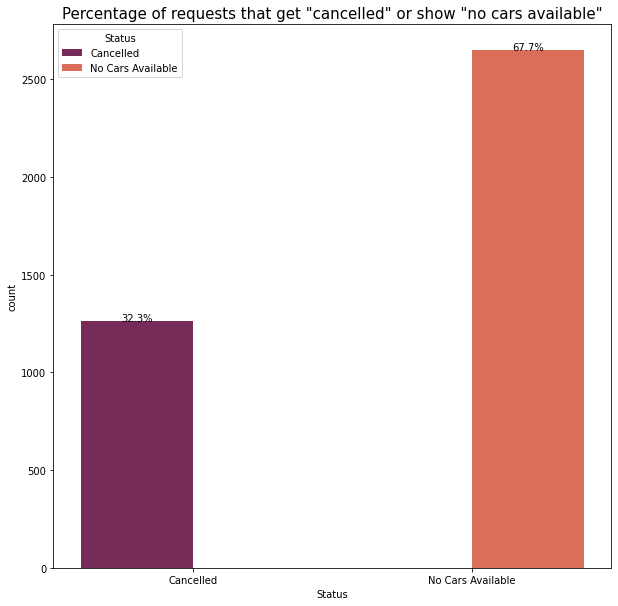

In [12]:
# Percentage of requests that get cancelled or show 'no cars available.

plt.figure(figsize = (10,10))

total = float(len(trips))

ax = sns.countplot(x = "Status", hue = "Status", data = trips, palette = "rocket")

plt.title('Percentage of requests that get "cancelled" or show "no cars available"', fontsize = 15)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 0.2
    ax.annotate(percentage, (x, y),ha = 'center')
plt.show()

* Percentage of "No cars available" is high.

In [29]:
# Grouping data by "Pickup point" and "Status".

problematic_requests = trips.groupby(["Pickup point", "Status"]).size().reset_index(name = "Frequency")

problematic_requests["Total_frequency"] = sum(problematic_requests["Frequency"])

problematic_requests["Percentage"] = (problematic_requests["Frequency"]/problematic_requests["Total_frequency"])*100

problematic_requests

,Pickup point,Status,Frequency,Total_frequency,Percentage
0,Airport,Cancelled,198,3914,5.058763
1,Airport,No Cars Available,1713,3914,43.765968
2,City,Cancelled,1066,3914,27.235565
3,City,No Cars Available,937,3914,23.939704


<Figure size 720x720 with 0 Axes>

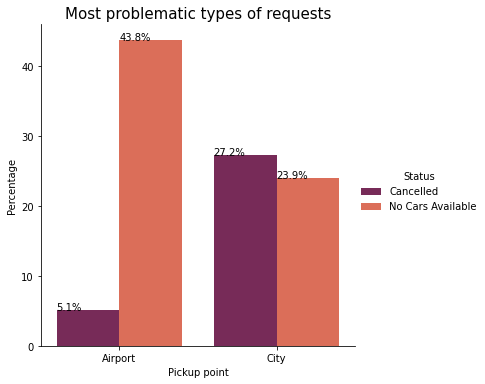

In [31]:
# Most problematic types of requests (city to airport / airport to city etc.).

plt.figure(figsize = (10,10))

plot = sns.catplot(x = 'Pickup point', y = 'Percentage', hue = 'Status', kind = 'bar', data = problematic_requests, palette = "rocket")

plt.title('Most problematic types of requests', fontsize = 15)

for p in plot.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    plot.ax.text(txt_x,txt_y,txt)
plt.show()   

* The percentage of cars getting cancelled and no cars available is high in City than Airport.
* Hence problematic type of request is City–Airport.

In [24]:
# Grouping data by "Time_slots" and "Status".

problematic_requests = trips.groupby(["Time_slots", "Status"]).size().reset_index(name = "Frequency")

problematic_requests["Total_frequency"] = sum(problematic_requests["Frequency"])

problematic_requests["Percentage"] = (problematic_requests["Frequency"]/problematic_requests["Total_frequency"])*100

problematic_requests

,Time_slots,Status,Frequency,Total_frequency,Percentage
0,Early Morning,Cancelled,62,3855,1.608301
1,Early Morning,No Cars Available,243,3855,6.303502
2,Morning,Cancelled,668,3855,17.328145
3,Morning,No Cars Available,323,3855,8.378729
4,Mid day,Cancelled,271,3855,7.029831
5,Mid day,No Cars Available,233,3855,6.044099
6,Afternoon,Cancelled,72,3855,1.867704
7,Afternoon,No Cars Available,184,3855,4.773022
8,Evening,Cancelled,124,3855,3.216602
9,Evening,No Cars Available,1127,3855,29.234760


<Figure size 720x720 with 0 Axes>

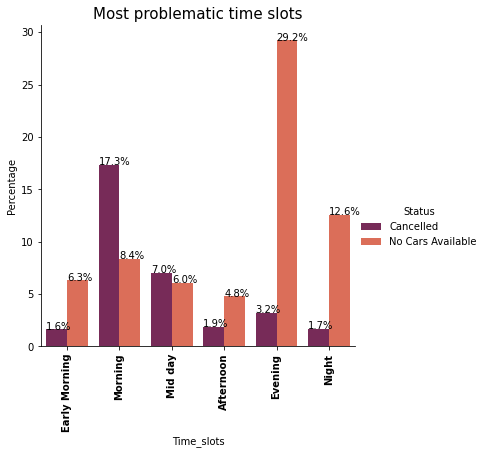

In [26]:
# Problematic time slots (early mornings, late evenings etc.).

plt.figure(figsize = (10,10))

plot = sns.catplot(x = 'Time_slots', y = 'Percentage', hue = 'Status', kind = 'bar', data = problematic_requests, palette = "rocket")

plt.title('Most problematic time slots', fontsize = 15)

plt.xticks(rotation = 90, fontweight = "bold")

for p in plot.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    plot.ax.text(txt_x,txt_y,txt)

Problematic time slots are "Morning" and "Evening". In "Morning" the pressing problem is trips getting "Cancelled" and in "Evening" the problem is "No Cars available". Therefore two pressing problems for Uber are:
* Trips getting "Cancelled in "Morning".
* "No cars available" in "Evening".

### **2. Finding out the gap between supply and demand.**

In [35]:
city_demand = len(uber_data[(uber_data['Pickup point'] == "City")])

city_demand

3507

In [36]:
city_supply = len(uber_data[(uber_data['Status'] == "Trip Completed") & (uber_data['Pickup point'] == "City")])

city_supply

1504

In [37]:
city_gap = city_demand - city_supply

city_gap

2003

In [38]:
Airport_demand = len(uber_data[(uber_data['Pickup point'] == "Airport")])

Airport_demand

3238

In [39]:
Airport_supply = len(uber_data[(uber_data['Status'] == "Trip Completed") & (uber_data['Pickup point'] == "Airport")])

Airport_supply

1327

In [40]:
Airport_gap = Airport_demand - Airport_supply

Airport_gap

1911

* There is more supply-demand gap in City.

### **Time slots when the highest gap exists.**

In [41]:
# Creating new column as "supply_demand".

uber_data["supply_demand"] = uber_data["Status"].apply(lambda x: 'Supply' if x == "Trip Completed" else 'Gap')

uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request_hour,Drop_hour,Time_slots,supply_demand
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,13.0,Mid day,Supply
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,18.0,Evening,Supply
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,9.0,Mid day,Supply
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,22.0,Night,Supply
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,9.0,Morning,Supply


In [44]:
# Grouping data by "Time_slots" and "supply_demand".

problematic_requests = uber_data.groupby(["Time_slots", "supply_demand"]).size().reset_index(name = "Frequency")

problematic_requests["Total_frequency"] = sum(problematic_requests["Frequency"])

problematic_requests["Percentage"] = (problematic_requests["Frequency"]/problematic_requests["Total_frequency"])*100

problematic_requests

,Time_slots,supply_demand,Frequency,Total_frequency,Percentage
0,Early Morning,Gap,305,6646,4.589227
1,Early Morning,Supply,174,6646,2.618116
2,Morning,Gap,991,6646,14.911225
3,Morning,Supply,681,6646,10.246765
4,Mid day,Gap,504,6646,7.583509
5,Mid day,Supply,525,6646,7.899488
6,Afternoon,Gap,256,6646,3.851941
7,Afternoon,Supply,370,6646,5.567259
8,Evening,Gap,1251,6646,18.823352
9,Evening,Supply,642,6646,9.659946


<Figure size 720x720 with 0 Axes>

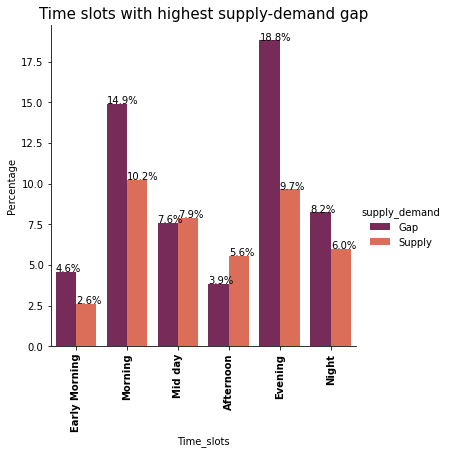

In [46]:
# Problematic time slots with highest supply-demand gap.

plt.figure(figsize = (10,10))

plot = sns.catplot(x = 'Time_slots', y = 'Percentage', hue = 'supply_demand', kind = 'bar', data = problematic_requests, palette = "rocket")

plt.title('Time slots with highest supply-demand gap', fontsize = 15)

plt.xticks(rotation = 90, fontweight = "bold")

for p in plot.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    plot.ax.text(txt_x,txt_y,txt)

* Percentage gap of "Evening" and "Morning" are high. Hence time slots for which gap is highest are "Evening" followed by "Morning".


### **Types of requests (city-airport or airport-city) for which the gap is the most severe in the identified time slots.**


In [61]:
# For city-Airport.

city = uber_data[(uber_data['Pickup point'] == "City")]

slots = ["Morning", "Evening"]

difficult_slots = city[city["Time_slots"].isin(slots)]

In [62]:
# Grouping data by "Time_slots" and "supply_demand".

problematic_requests = difficult_slots.groupby(["Time_slots", "supply_demand"]).size().reset_index(name = "Frequency")

problematic_requests["Total_frequency"] = sum(problematic_requests["Frequency"])

problematic_requests["Percentage"] = (problematic_requests["Frequency"]/problematic_requests["Total_frequency"])*100

problematic_requests

,Time_slots,supply_demand,Frequency,Total_frequency,Percentage
0,Early Morning,Gap,0,1771,0.000000
1,Early Morning,Supply,0,1771,0.000000
2,Morning,Gap,962,1771,54.319593
3,Morning,Supply,373,1771,21.061547
4,Mid day,Gap,0,1771,0.000000
5,Mid day,Supply,0,1771,0.000000
6,Afternoon,Gap,0,1771,0.000000
7,Afternoon,Supply,0,1771,0.000000
8,Evening,Gap,106,1771,5.985319
9,Evening,Supply,330,1771,18.633540


<Figure size 720x720 with 0 Axes>

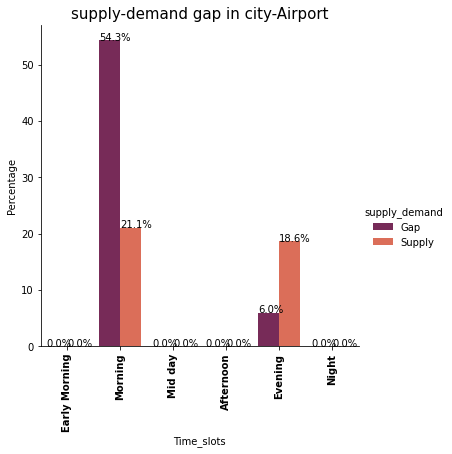

In [63]:
# Type of request for which supply-demand gap is more.

plt.figure(figsize = (10,10))

plot = sns.catplot(x = 'Time_slots', y = 'Percentage', hue = 'supply_demand', kind = 'bar', data = problematic_requests, palette = "rocket")

plt.title('supply-demand gap in city-Airport', fontsize = 15)

plt.xticks(rotation = 90, fontweight = "bold")

for p in plot.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    plot.ax.text(txt_x,txt_y,txt)

* In City-Airport, gap is high in Morning.

In [64]:
# For Airport-City.

city = uber_data[(uber_data['Pickup point'] == "Airport")]

slots = ["Morning", "Evening"]

difficult_slots = city[city["Time_slots"].isin(slots)]

In [65]:
# Grouping data by "Time_slots" and "supply_demand".

problematic_requests = difficult_slots.groupby(["Time_slots", "supply_demand"]).size().reset_index(name = "Frequency")

problematic_requests["Total_frequency"] = sum(problematic_requests["Frequency"])

problematic_requests["Percentage"] = (problematic_requests["Frequency"]/problematic_requests["Total_frequency"])*100

problematic_requests

,Time_slots,supply_demand,Frequency,Total_frequency,Percentage
0,Early Morning,Gap,0,1794,0.000000
1,Early Morning,Supply,0,1794,0.000000
2,Morning,Gap,29,1794,1.616499
3,Morning,Supply,308,1794,17.168339
4,Mid day,Gap,0,1794,0.000000
5,Mid day,Supply,0,1794,0.000000
6,Afternoon,Gap,0,1794,0.000000
7,Afternoon,Supply,0,1794,0.000000
8,Evening,Gap,1145,1794,63.823857
9,Evening,Supply,312,1794,17.391304


<Figure size 720x720 with 0 Axes>

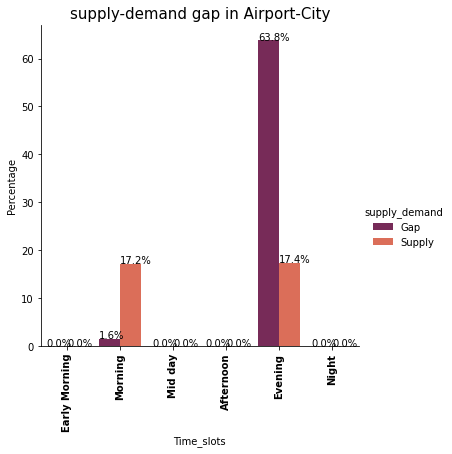

In [66]:
# Type of request for which supply-demand gap is more.

plt.figure(figsize = (10,10))

plot = sns.catplot(x = 'Time_slots', y = 'Percentage', hue = 'supply_demand', kind = 'bar', data = problematic_requests, palette = "rocket")

plt.title('supply-demand gap in Airport-City', fontsize = 15)

plt.xticks(rotation = 90, fontweight = "bold")

for p in plot.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    plot.ax.text(txt_x,txt_y,txt)

* In Airport-City, gap is high in Evening.


### **Determining inflow and outflow of cars to and from airport respectively to understand idle time.**

In [67]:
# Determing inflow and outflow of cars.

inflow = uber_data[(uber_data['Status'] == "Trip Completed") & (uber_data['Pickup point'] == "City")]

outflow = uber_data[(uber_data['Status'] == "Trip Completed") & (uber_data['Pickup point'] == "Airport")]

In [70]:
# Using describe to find out number of cars going in and out of airport during different time slots.

inflow["Time_slots"].value_counts().sum()


1487

In [72]:
outflow["Time_slots"].value_counts().sum()

1304

* Number of cars entering airport are more than leaving. This leads to idle time showing up at different time slots which can be a cause of trip cancellations.


### **Conclusions:**

### **Reasons for Supply-Demand gap:**

Reason 1: “No Cars Available” in “Evening” from “Airport – City”.
* This may be because of lack of cars at the location of request and
* Because of Lack of drivers. 

Reason 2: “Cancellations” in “Morning” from “City – Airport”.
* Imbalance in inflow and outflow of cars from airport causing idle time thereby resulting in cancellations by driver.
* Driver has to travel more distance to get to the Airport. So if he returns empty, then it is waste of fuel.
* Instead of distant trips, driver can make more number of trips of shorter distance. Hence make more money.

